#### Reinforcement Learning 

# Setup 

In [1]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='any') # Available options are 'cpu', 'gpu', and ‘any'.

import numpy as np
import os


np.random.seed(211121)
tf.random.set_seed(211121)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

PROJECT_ROOT_DIR = '.'
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png',resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure",fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introduction to OpenAI gym 

In [2]:
import gym
gym.envs.registry.all()

dict_values([EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v1), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v1), EnvSpec(FrozenLake-v1), EnvSpec(FrozenLake8x8-v1), EnvSpec(CliffWalking-v0), EnvSpec(Taxi-v3), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSpec(Swimmer-v3), EnvSpec(Walker2d-v2), EnvSpec(Walker2d-v3), EnvSpec(Ant-v2), EnvSpec(Ant-v3), EnvSpec(Humanoid-v2), EnvSpec(Humanoid-v3), EnvSpec(HumanoidStandup-v2), EnvSpec(FetchSlide-v1), EnvSpec(FetchPickAndPlace-v1), EnvSpec(FetchReach-v1), EnvSpec(FetchPush-v1), EnvSpec(HandReach-v0), EnvSpec(HandManipula

카트 위에 놓인 물체가 넘어지지 않도록 왼쪽이나 오른쪽으로 가속할 수 있는 2D 시뮬레이션

In [3]:
env = gym.make("CartPole-v1")
env.seed(211121)
obs = env.reset()

cart's horizontal position, its velocity, the angle of the pole (0=vertical), and the angular velocity

In [4]:
obs

array([ 0.0286769 , -0.04789421, -0.01538193,  0.04086329], dtype=float32)

In [5]:
env.render()

True

In [6]:
img = env.render( mode='rgb_array')
img.shape

(800, 1200, 3)

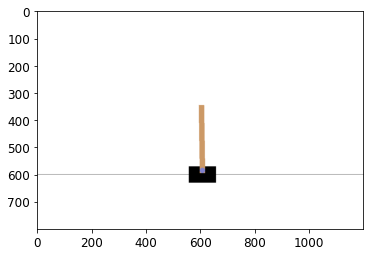

In [7]:
plt.imshow(img)

In [8]:
def plot_environment(env, figsize=(7.5, 6)):
    plt.figure(figsize=figsize)
    img = env.render(mode='rgb_array')
    plt.imshow(img)
    plt.axis('off')
    return img
    

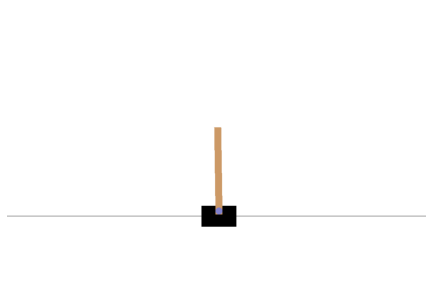

In [9]:
plot_environment(env)
plt.show()

In [10]:
env.action_space

Discrete(2)

In [11]:
obs[2]

-0.015381934

In [12]:
action = 0 #accelerate right
obs, reward, done, info = env.step(action)
#매 스텝마다 1의 reward를 받음. 시스템의 목적은 가능한 오랫동안 생존하는 것
obs

array([ 0.02771901, -0.24279225, -0.01456467,  0.32865363], dtype=float32)

Saving figure cart_pole_plot


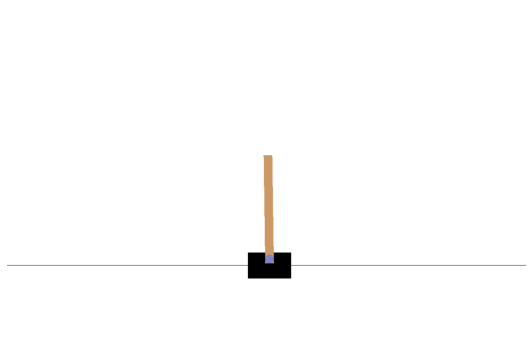

In [13]:
plot_environment(env)
save_fig("cart_pole_plot")

env가 reset되어 끝날 때 사이의 step들을 "episode"라고 부름.
done=True이 반환되면, env를 다시 reset해줘야 함

In [14]:
if done:
    obs = env.reset()

# A simple hard-coded policy
일단 간단한 정책 적용. 막대가 왼쪽으로 기울면, 카트를 왼쪽으로 가속하고 vice versa.

In [15]:
env.seed(211121)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for i in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [16]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.116, 8.518834662088473, 24.0, 67.0)

basic policy는 그닥 좋은 성능은 아님.
episode 하나만 떼서 시각화해보자

In [17]:
env.seed(211121)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode='rgb_array')
    frames.append(img)
    action = basic_policy(obs)
    
    obs, reward, done, info = env.step(action)
    if done:
        break

In [18]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames,patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [19]:
plot_animation(frames)

# Neural Network Policies
관륵을 입력으로 받고, 실행할 행동에 대한 확률을 추정.
E&E (exploration&exploitatin) 정책을 사용하여, 확률에 따라 바로 선택하지 않고 확률을 기반으로 랜덤하게 선택함.
본 게임에서 행동은 두가지이므로, 출력은 하나만 나오면 됨. 다른 하나의 행동에 대한 확률은 (1-p)

In [20]:
keras.backend.clear_session()
tf.random.set_seed(211121)
np.random.seed(211121)

n_inputs = env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')])
#하나의 확률이 필요하므로 activation function으로 sigmoid면 됨.
#두 개보다 많은 행동 중에 선택이라면 softmax 함수를 사용해야 함.

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 25        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [22]:
def render_policy_net(model, n_max_steps=200, seed=211121):
    frames = []
    env = gym.make('CartPole-v1')
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode='rgb_array'))
        left_proba = model.predict(obs.reshape(1,-1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [23]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(211121)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 3.522

In [24]:
frames = render_policy_net(model)
plot_animation(frames)

2021-11-24 19:52:26.287174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-24 19:52:26.287299: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


# Policy Gradients 

In [25]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1,1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0,0].numpy()))
    return obs, reward, done, grads

In [26]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model,loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs,reward,done,grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [27]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step +1] * discount_rate
    return discounted

In [28]:
def discount_and_normalize_rewards(all_rewards,discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [ (discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [29]:
#example
discount_rewards([10,0,-50], discount_rate=0.8)

array([-22, -40, -50])

In [34]:
n_iterations = 1
n_episodes_per_update = 10
n_max_steps = 300
discount_rate = 0.95

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu'),
    keras.layers.Dense(1, activation='sigmoid')])

In [37]:
env = gym.make('CartPole-v1')
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 0, mean rewards: 21.0

In [39]:
frames = render_policy_net(model)
plot_animation(frames)

2021-11-24 19:53:39.762 python[3664:547677] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


# Markov chains  

In [40]:
np.random.seed(42)

# MDP(markov decision process) 정의
transition_probabilities = [
    [0.7, 0.2, 0.0, 0.1],
    [0.0, 0.0, 0.9, 0.1],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]]

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end="")
    for step in range(n_max_steps):
        print(current_state, end="")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()
        
for _ in range(10):
    print_sequence()

States:003
States:01212121213
States:01212121212121212121213
States:03
States:01212121212121213
States:013
States:01212121212121212121212121212121212121212121212121...
States:003
States:000121213
States:01212121212121212121213


# Markov Decision Process 

In [41]:
transition_probabilities = [ # shape = [s,a,s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]]
rewards = [
    [[10, 0, 0],[0,0,0],[0,0,0]],
    [[0,0,0],[0,0,0],[0,0,-50]],
    [[0,0,0],[40,0,0],[0,0,0]],
    [[0,0,0],[40,0,0],[0,0,0]]]
possible_actions = [[0,1,2], [0,2], [1]]

# Q-Value Iteration 

In [42]:
Q_values = np.full((3,3), -np.inf) #가능한 행동만 0, 아니면 음의 무한대
for state, actions in enumerate(possible_actions):
    Q_values[state,actions] = 0.0

In [43]:
gamma = 0.90 #discount factor, 클수록 미래 보상에 더 가치를 두는

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s,a] = np.sum([
                transition_probabilities[s][a][sp]
                * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

In [44]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [45]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

# Q-Learning 

In [46]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0,1,2],p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [47]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [48]:
np.random.seed(42)

Q_values = np.full((3,3),-np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0
    
alpha0 = 0.05 #initial learning rate
decay = 0.005 #learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1+iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

Saving figure q_value_plot


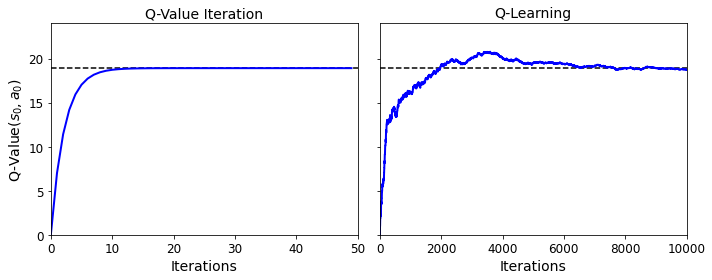

In [49]:
history1 = np.array(history1)
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")


# Deep Q-Network 

In [50]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])


In [51]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [52]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [53]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [54]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [55]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [56]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

In [57]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}, best score:{}".format(episode, step + 1, epsilon, best_score), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 42, eps: 0.010, best score:1199

Saving figure dqn_rewards_plot


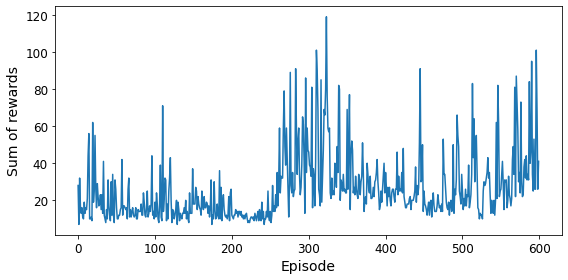

In [58]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()


In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)